# Example solution


# Import libraries and personal funtions

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
# import utility to select a random subset of the training set as validation
from torch.utils.data.sampler import  SubsetRandomSampler

# Get dataset

In [2]:
# Load the FashionMNIST dataset
train_dataset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', train=True, download=True,
                                     transform=transforms.ToTensor())
train_data = train_dataset.data.numpy()

# Calculate the mean and standard deviation
mean = np.mean(train_data) / 255.0
std = np.std(train_data) / 255.0

print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")

100%|██████████| 26.4M/26.4M [00:02<00:00, 9.87MB/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 165kB/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.15MB/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 21.0MB/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw

Mean: 0.2860405969887955
Standard Deviation: 0.3530242445149223


In [3]:
batch_size = 128

In [4]:
# define a transform to convert to images to tensor and normalize
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.28,),(0.35,),)]) #mean and std have to be sequences (e.g., tuples),
                                                                      # therefore we should add a comma after the values

# load the data: train and test sets
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=False, transform=transform)

# preparing indices for validation set
indices = list(range(len(trainset)))

# selected as get 20% of the train set
split = int(np.floor(0.2 * len(trainset)))
train_sample = SubsetRandomSampler(indices[:split])
valid_sample = SubsetRandomSampler(indices[split:])

# define the data loader
trainloader = torch.utils.data.DataLoader(trainset, sampler=train_sample, batch_size=batch_size)
validloader = torch.utils.data.DataLoader(trainset, sampler=valid_sample, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

In [5]:
trainset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /root/.pytorch/F_MNIST_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.28,), std=(0.35,))
           )

# Visualize dataset

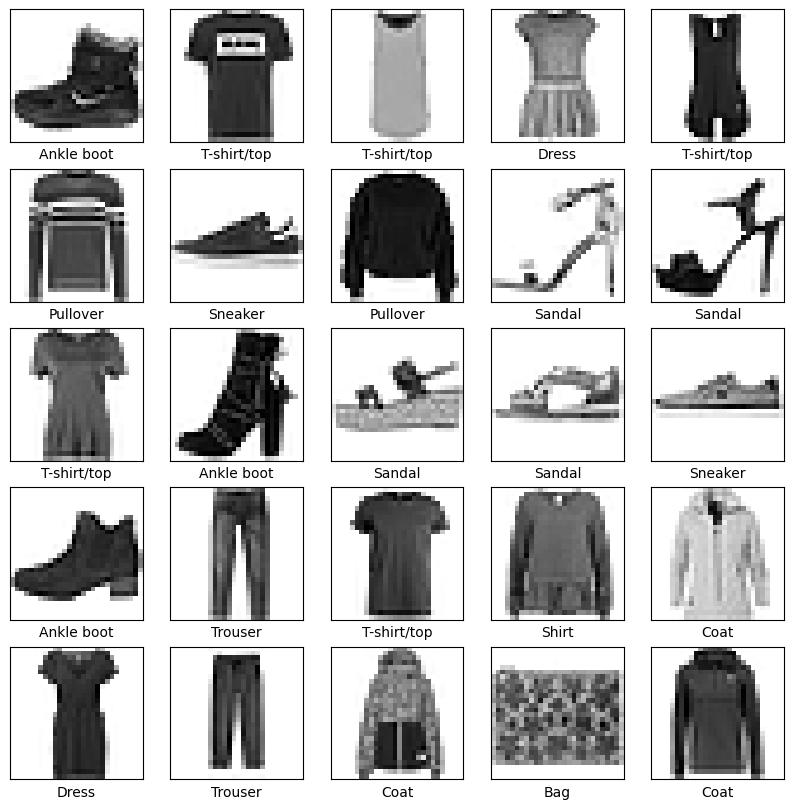

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

# visualizzo alcuni esempi
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img, label = trainset[i]
    plt.imshow(img.squeeze(), cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
plt.show()

# **Building the Network**

In [7]:
# Define the MLP network
n1 = 256
n2 = 128

class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784, n1)
    self.fc2 = nn.Linear(n1, n2)
    self.fc3 = nn.Linear(n2,10)


  def forward(self,x):
    # flatten the image to a 2D vector
    x = x.view(x.shape[0],-1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))


    return x


In [8]:
model = Classifier()
print(model)

Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)



cuda


In [10]:
!pip install torchsummary
# A library to demonstrate torch model like keras

model.to(device)

from torchsummary import summary
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
            Linear-2                  [-1, 128]          32,896
Total params: 233,856
Trainable params: 233,856
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.89
Estimated Total Size (MB): 0.90
----------------------------------------------------------------


# Training

In [11]:
def train(model, trainloader, validloader, device, optimizer, epochs=10):
  """
  Trains a PyTorch model and returns the training and validation losses.

  Args:
    model: The PyTorch model to train.
    trainloader: The DataLoader for the training set.
    validloader: The DataLoader for the validation set.
    epochs: The number of training epochs.
    learning_rate: The learning rate for the optimizer.

  Returns:
    train_losses: A list of training losses for each epoch.
    valid_losses: A list of validation losses for each epoch.
  """
  criterion = nn.CrossEntropyLoss()


  train_losses = []
  valid_losses = []

  for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for images, labels in trainloader:
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

    train_loss = running_loss / len(trainloader)
    train_losses.append(train_loss)

    # Validation
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    with torch.no_grad():
      for images, labels in validloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

    valid_loss = running_loss / len(validloader)
    valid_losses.append(valid_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

  return train_losses, valid_losses

In [12]:
# function for evaluation/test
def test(model, device, test_loader):
    model.eval()  # model to eval
    test_loss = 0
    correct = 0

    # ITERATE DATALOADER: test_loader
    for data, target in test_loader:
        batch_size = data.shape[0]
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss

        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

        # sanity check
        pred = pred.view(batch_size)  # [bs,]
        target = target.view(batch_size)  # [bs,]

        # compute prediction ok
        batch_pred_ok = pred.eq(target).sum().item()
        correct += batch_pred_ok

    test_loss /= len(test_loader.dataset)
    num_samples = len(test_loader.dataset)
    test_accuracy = correct / num_samples
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [13]:
# training hyperparameters
lr = 0.01
num_epochs = 20
print(f"lr: {lr}")
print(f"batch size: {batch_size}")
print(f"Num. optimization steps per-epoch: {int(len(train_dataset)/batch_size)}")

lr: 0.01
batch size: 128
Num. optimization steps per-epoch: 468


In [14]:
#############
# OPTIMIZER #
#############
parameters_to_optimize = model.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=lr, momentum=0.9)

In [15]:
train_losses, valid_losses = train(model, trainloader, validloader, device, optimizer, num_epochs)



Epoch [1/20], Train Loss: 1.6299, Valid Loss: 1.0447
Epoch [2/20], Train Loss: 1.0125, Valid Loss: 0.9728
Epoch [3/20], Train Loss: 0.9581, Valid Loss: 0.9428
Epoch [4/20], Train Loss: 0.9195, Valid Loss: 0.9308
Epoch [5/20], Train Loss: 0.8962, Valid Loss: 0.8086
Epoch [6/20], Train Loss: 0.4425, Valid Loss: 0.4439
Epoch [7/20], Train Loss: 0.3803, Valid Loss: 0.4228
Epoch [8/20], Train Loss: 0.3479, Valid Loss: 0.4013
Epoch [9/20], Train Loss: 0.3334, Valid Loss: 0.4228
Epoch [10/20], Train Loss: 0.3129, Valid Loss: 0.3940
Epoch [11/20], Train Loss: 0.2982, Valid Loss: 0.3827
Epoch [12/20], Train Loss: 0.2912, Valid Loss: 0.3897
Epoch [13/20], Train Loss: 0.2747, Valid Loss: 0.3929
Epoch [14/20], Train Loss: 0.2635, Valid Loss: 0.4040
Epoch [15/20], Train Loss: 0.2607, Valid Loss: 0.4076
Epoch [16/20], Train Loss: 0.2471, Valid Loss: 0.3854
Epoch [17/20], Train Loss: 0.2332, Valid Loss: 0.3900
Epoch [18/20], Train Loss: 0.2236, Valid Loss: 0.4078
Epoch [19/20], Train Loss: 0.2248, Va

# Plot Training

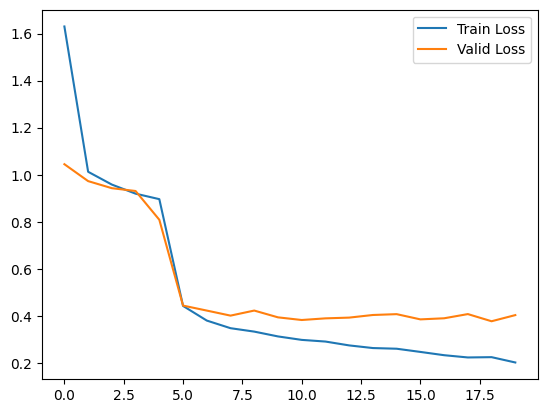

In [16]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')

plt.legend()

# **Test the trained network**

In [17]:
test(model, device, testloader)



Test set: Average loss: 0.4337, Accuracy: 8517/10000 (85%)



# CNN model

###  For this Section , restart the Kernel and Use GPU


In [18]:
# Build the neural network, expand on top of nn.Module
class CnnClassifier(nn.Module):
  def __init__(self):
    super().__init__()

    # define layers
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3)
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)

    self.flatten = nn.Flatten()

    self.fc1 = nn.Linear(in_features=3200, out_features=60)
    self.out = nn.Linear(in_features=60, out_features=10)

  # define forward function
  def forward(self, t):
    # conv 1
    t = self.conv1(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    # conv 2
    t = self.conv2(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    # fc1
    t = self.flatten(t)
    t = self.fc1(t)
    t = F.relu(t)


    # output
    t = self.out(t)

    # don't need softmax here since we'll use cross-entropy as activation.

    return t

In [19]:
# Enabling GPU
model = CnnClassifier()
model.to(device)
print(model)

CnnClassifier(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3200, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)


In [20]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 26, 26]             640
            Conv2d-2          [-1, 128, 11, 11]          73,856
           Flatten-3                 [-1, 3200]               0
            Linear-4                   [-1, 60]         192,060
            Linear-5                   [-1, 10]             610
Total params: 267,166
Trainable params: 267,166
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.47
Params size (MB): 1.02
Estimated Total Size (MB): 1.50
----------------------------------------------------------------


# Training

In [21]:
# training hyperparameters
lr = 0.01
num_epochs = 10

print(f"lr: {lr}")
print(f"batch size: {batch_size}")
print(f"Num. optimization steps per-epoch: {int(len(train_dataset)/batch_size)}")


lr: 0.01
batch size: 128
Num. optimization steps per-epoch: 468


In [22]:
#############
# OPTIMIZER #
#############
parameters_to_optimize = model.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=lr, momentum=0.9)

In [23]:
train_losses, valid_losses = train(model, trainloader, validloader, device, optimizer, num_epochs)



Epoch [1/10], Train Loss: 1.1098, Valid Loss: 0.6619
Epoch [2/10], Train Loss: 0.5722, Valid Loss: 0.5733
Epoch [3/10], Train Loss: 0.5011, Valid Loss: 0.4644
Epoch [4/10], Train Loss: 0.4372, Valid Loss: 0.4283
Epoch [5/10], Train Loss: 0.4002, Valid Loss: 0.4157
Epoch [6/10], Train Loss: 0.3835, Valid Loss: 0.3903
Epoch [7/10], Train Loss: 0.3490, Valid Loss: 0.3839
Epoch [8/10], Train Loss: 0.3313, Valid Loss: 0.3673
Epoch [9/10], Train Loss: 0.3003, Valid Loss: 0.3787
Epoch [10/10], Train Loss: 0.2925, Valid Loss: 0.3511


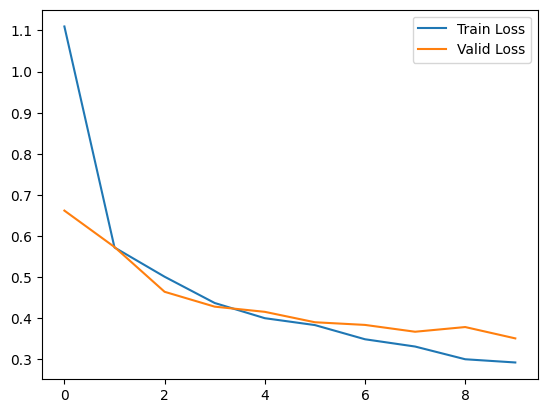

In [24]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')

plt.legend()

# **Test the trained network**

In [25]:
test(model, device, testloader)



Test set: Average loss: 0.3693, Accuracy: 8706/10000 (87%)

